In [4]:
!pip install lightgbm 

Defaulting to user installation because normal site-packages is not writeable
  Using cached lightgbm-3.3.3-py3-none-win_amd64.whl (1.0 MB)


In [28]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

import string
from tqdm.notebook import tqdm
import matplotlib
from sklearn.metrics import classification_report

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import pymorphy2

from sklearn.decomposition import TruncatedSVD
import matplotlib.patches as mpatches

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import tika
from tika import parser
import re
import os
from sklearn.preprocessing import LabelEncoder

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\isdom\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\isdom\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\isdom\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\isdom\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [29]:
classes = pd.read_json('classes.json', orient='index') #перевод в пандас фрейм

In [30]:
classes.head(2)

,0
5908cb5da047d6c9e6dfea6337fb3189.doc,Договоры для акселератора/Договоры поставки
14711e4fc8e56f0c75856c8837ec04cb.doc,Договоры для акселератора/Договоры поставки


In [31]:
list_docs = os.listdir('docs')

In [32]:
tika.initVM()

for doc in tqdm(list_docs):
  parsed = parser.from_file('docs/' + doc)
  # classes.loc[doc, 'metadata'] = parsed["metadata"]
  classes.loc[doc, 'content'] = parsed["content"]

  0%|          | 0/120 [00:00<?, ?it/s]

In [33]:
%%time
stop_words = set(stopwords.words('russian')) # множество стоп слов

morph = pymorphy2.MorphAnalyzer() # для постановки слова в начальную форму

def lemmatize_words(text):
    '''Функция для лемматизации отдельных слов.'''
    final_text = []
    for i in text.lower().split():
        if i not in stop_words:
            parse = morph.parse(i)[0]
            if ('Abbr' not in parse.tag):
                final_text.append(parse.normal_form)               
    return " ".join(final_text)

def text_preprocessing(text):
    data = text.copy()

    # удаляем пунктуацию
    data['content_punct'] = data['content'].str.translate(str.maketrans('', '', string.punctuation))
    # Приводим к начальной форме
    data['content_punct_lemm'] = data['content_punct'].apply(lemmatize_words)
    
    return data

classes_prep = text_preprocessing(classes)
classes_prep
# test_copy = test.copy()
# test_copy.rename(columns={'text': 'sentence'}, inplace=True)
# test_prep = text_preprocessing(test_copy.fillna('нет текста'))

2022-12-16 17:06:47.257 Loading dictionaries from C:\Users\isdom\AppData\Roaming\Python\Python39\site-packages\pymorphy2_dicts_ru\data
2022-12-16 17:06:47.357 format: 2.4, revision: 417127, updated: 2020-10-11T15:05:51.070345


Wall time: 32.9 s


,0,content,content_punct,content_punct_lemm
5908cb5da047d6c9e6dfea6337fb3189.doc,Договоры для акселератора/Договоры поставки,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,договор поставка оборудование № 22лп10 8 догов...
14711e4fc8e56f0c75856c8837ec04cb.doc,Договоры для акселератора/Договоры поставки,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,договор куплипродажа № договор № дата место за...
7eb67b5aecf3f3190aab0a5f8ea32172.docx,Договоры для акселератора/Договоры поставки,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,типовой договор возмездный оказание услуга дог...
b40a9d048b199d5f4db62a6a2335f2a0.pdf,Договоры для акселератора/Договоры поставки,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,microsoft word договор поставка товаровdocx до...
84fec112d02288861e7af59f468131fb.docx,Договоры для акселератора/Договоры поставки,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,договор № номердокумент датадокумент названиек...
...,...,...,...,...
f57fe87f15a6dee2b17e804421be63b5.pdf,Договоры для акселератора/Договоры купли-продажи,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,страница 1 8 договор куплипродажа ……… оборудов...
1ea8809d696a4bd6a2076fbc6fd28c23.doc,Договоры для акселератора/Договоры купли-продажи,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,договор № договор москва «» 2020 год год рожде...
57962abd8dbe0ce0c7056896ee4501f1.doc,Договоры для акселератора/Договоры купли-продажи,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,договор № предварительный договор москва «» 20...
2c81df29db63aebf495106881a52188f.doc,Договоры для акселератора/Договоры купли-продажи,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,договор куплипродажа договор № 2004г именовать...


In [34]:
le = LabelEncoder()
classes_prep['labels'] = le.fit_transform(classes_prep[0])
classes_prep

,0,content,content_punct,content_punct_lemm,labels
5908cb5da047d6c9e6dfea6337fb3189.doc,Договоры для акселератора/Договоры поставки,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,договор поставка оборудование № 22лп10 8 догов...,4
14711e4fc8e56f0c75856c8837ec04cb.doc,Договоры для акселератора/Договоры поставки,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,договор куплипродажа № договор № дата место за...,4
7eb67b5aecf3f3190aab0a5f8ea32172.docx,Договоры для акселератора/Договоры поставки,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,типовой договор возмездный оказание услуга дог...,4
b40a9d048b199d5f4db62a6a2335f2a0.pdf,Договоры для акселератора/Договоры поставки,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,microsoft word договор поставка товаровdocx до...,4
84fec112d02288861e7af59f468131fb.docx,Договоры для акселератора/Договоры поставки,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,договор № номердокумент датадокумент названиек...,4
...,...,...,...,...,...
f57fe87f15a6dee2b17e804421be63b5.pdf,Договоры для акселератора/Договоры купли-продажи,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,страница 1 8 договор куплипродажа ……… оборудов...,1
1ea8809d696a4bd6a2076fbc6fd28c23.doc,Договоры для акселератора/Договоры купли-продажи,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,договор № договор москва «» 2020 год год рожде...,1
57962abd8dbe0ce0c7056896ee4501f1.doc,Договоры для акселератора/Договоры купли-продажи,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,договор № предварительный договор москва «» 20...,1
2c81df29db63aebf495106881a52188f.doc,Договоры для акселератора/Договоры купли-продажи,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,договор куплипродажа договор № 2004г именовать...,1


In [9]:
classes_prep[0].value_counts()

Договоры для акселератора/Договоры оказания услуг    32
Договоры для акселератора/Договоры аренды            23
Договоры для акселератора/Договоры купли-продажи     23
Договоры для акселератора/Договоры поставки          21
Договоры для акселератора/Договоры подряда           21
Name: 0, dtype: int64

In [10]:
def plot_LSA(test_data, test_labels):
    '''
    Функция для уменьшения размерности и визуализации векторного представления текстов по классам в проекции на плоскость
    '''
    lsa = TruncatedSVD(n_components=2)
    lsa.fit(test_data)
    lsa_scores = lsa.transform(test_data)
    colors = ['orange','blue','blue']
    plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=0.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
    red_patch = mpatches.Patch(color='orange', label='0')
    green_patch = mpatches.Patch(color='blue', label='1')
    plt.legend(handles=[red_patch, green_patch], prop={'size': 12})
    plt.title('Визуализация векторного представления текстов в проекции на плоскость', fontsize=14)

def plot_feature_importance(importance, names, model_name, numb_of_features=10):
    '''
    Для построения важности признаков
    '''
    # DataFrame из важности признаков модели с именами столбцов
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    # Сортируем по убыванию
    fi_df_sort = fi_df.sort_values(by=['feature_importance'], ascending=False)
    
    # Строим график
    if model_name == 'LogisticRegression':
        fig,ax = plt.subplots(2,1, figsize=(10,16))
        sns.barplot(x='feature_importance', y='feature_names', data=fi_df_sort[:numb_of_features], ax=ax[0])
        sns.barplot(x='feature_importance', y='feature_names', data=fi_df_sort[-numb_of_features:],ax=ax[1])
    else:
        fig,ax = plt.subplots(1,1, figsize=(10,8))
        sns.barplot(x='feature_importance', y='feature_names', data=fi_df_sort[:numb_of_features])
        
    plt.title(model_name + ' FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    plt.show()
    

def learning(X_train, X_test, y_train, y_test, classifier, name_of_classifier, plot_lsa=False,
             ngram_range_user=(1,1), numb_of_features_user=10):
    '''
    Обучение модели. Возвращаем TfidfVectorizer для теста и обученный классификатор
    '''
    
    tf=TfidfVectorizer(ngram_range=ngram_range_user) #нграм последовательности слов 1-1 только отдельные слова столбец в пандасе с тексстами
    X_train_tf = tf.fit_transform(X_train)
    X_test_tf = tf.transform(X_test)
    if plot_lsa == True:
        fig = plt.figure(figsize=(10, 8)) 
        plot_LSA(X_train_tf, y_train)
        plt.show()
    
    classifier.fit(X_train_tf, y_train)
    classifier_pred = classifier.predict(X_test_tf)
    classifier_pred_proba = classifier.predict_proba(X_test_tf)
    
    # print('{} confusion_matrix: \n'.format(name_of_classifier), confusion_matrix(y_test, classifier_pred))
    print('{} classification_report: \n'.format(name_of_classifier), classification_report(y_test, classifier_pred))
    # print('{} roc_auc: '.format(name_of_classifier), roc_auc_score(y_test, classifier_pred_proba, multi_class="ovr"))
    
    if name_of_classifier == 'LogisticRegression':
        plot_feature_importance(classifier.coef_[0],
                                list(tf.vocabulary_.keys()), name_of_classifier, numb_of_features=numb_of_features_user)
    else:
        plot_feature_importance(classifier.feature_importances_,
                                list(tf.vocabulary_.keys()), name_of_classifier, numb_of_features=numb_of_features_user)
        
    return tf, classifier

In [40]:
# Делим на обучающую и тестовую выборку
X_train, X_test, y_train, y_test = train_test_split(classes_prep['content_punct_lemm'],
                                                    classes_prep['labels'],
                                                    test_size=0.2, random_state=42,
                                                    stratify=classes_prep['labels'])
X_train

6b18c046e7ccfdaf9123c11980f56c35.doc     договор именовать дальнейший заказчик один сто...
084edc7dfc3db04e3a3c55c102f47bcb.doc     договор аренда земельный участок 2 5 договор №...
7eb67b5aecf3f3190aab0a5f8ea32172.docx    типовой договор возмездный оказание услуга дог...
f3734851311f2a7ac6c66ad7ccbe1d2c.doc     httpwwwknkrasru договор «» 201г наименование о...
453b2cb6e4ba7b8d1a8382773880d313.doc     договор № москва «» 2020 заказчик «компания за...
                                                               ...                        
a7966d0674c94a6e752e3a5832edb2a9.doc     договор строительный подряд договор «» именова...
2b408919fd9833dc3f6892aad753f21f.docx    договор подряд № номердокумент датадокумент на...
a8a9861b63d26f13f0f10a075158b6da.doc     договор финансовый аренда лизинг № 36л2006 дог...
5262e9c377c3ab1f6b8141762cca69ad.doc     договор куплипродажа договор « » 200г » именов...
18d573815c15b4e798bdfbfb52fb2f43.docx    образец договор проведение банкет заключать фи...

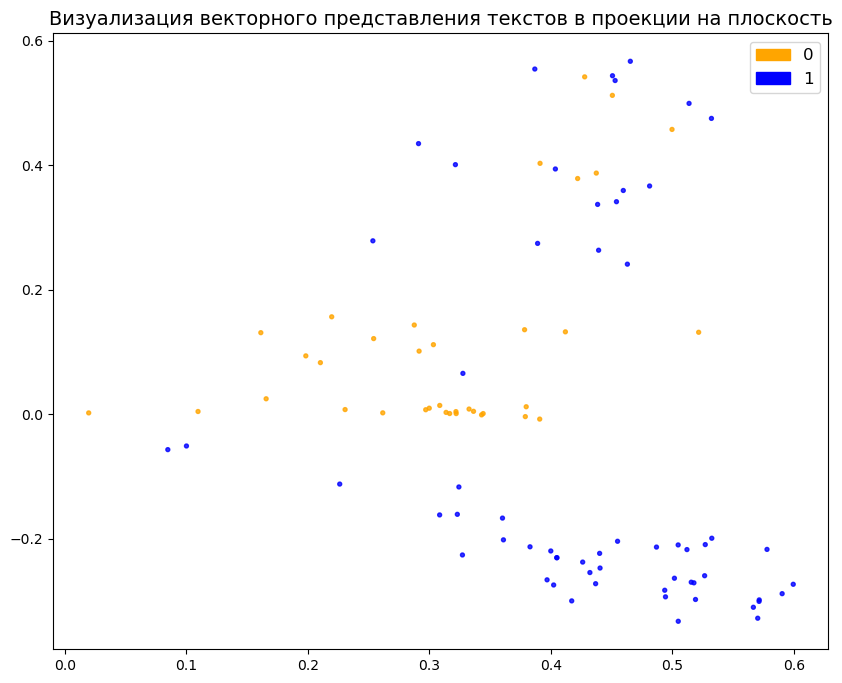

LogisticRegression classification_report: 
               precision    recall  f1-score   support

           0       1.00      0.80      0.89         5
           1       1.00      1.00      1.00         5
           2       0.86      1.00      0.92         6
           3       1.00      1.00      1.00         4
           4       1.00      1.00      1.00         4

    accuracy                           0.96        24
   macro avg       0.97      0.96      0.96        24
weighted avg       0.96      0.96      0.96        24



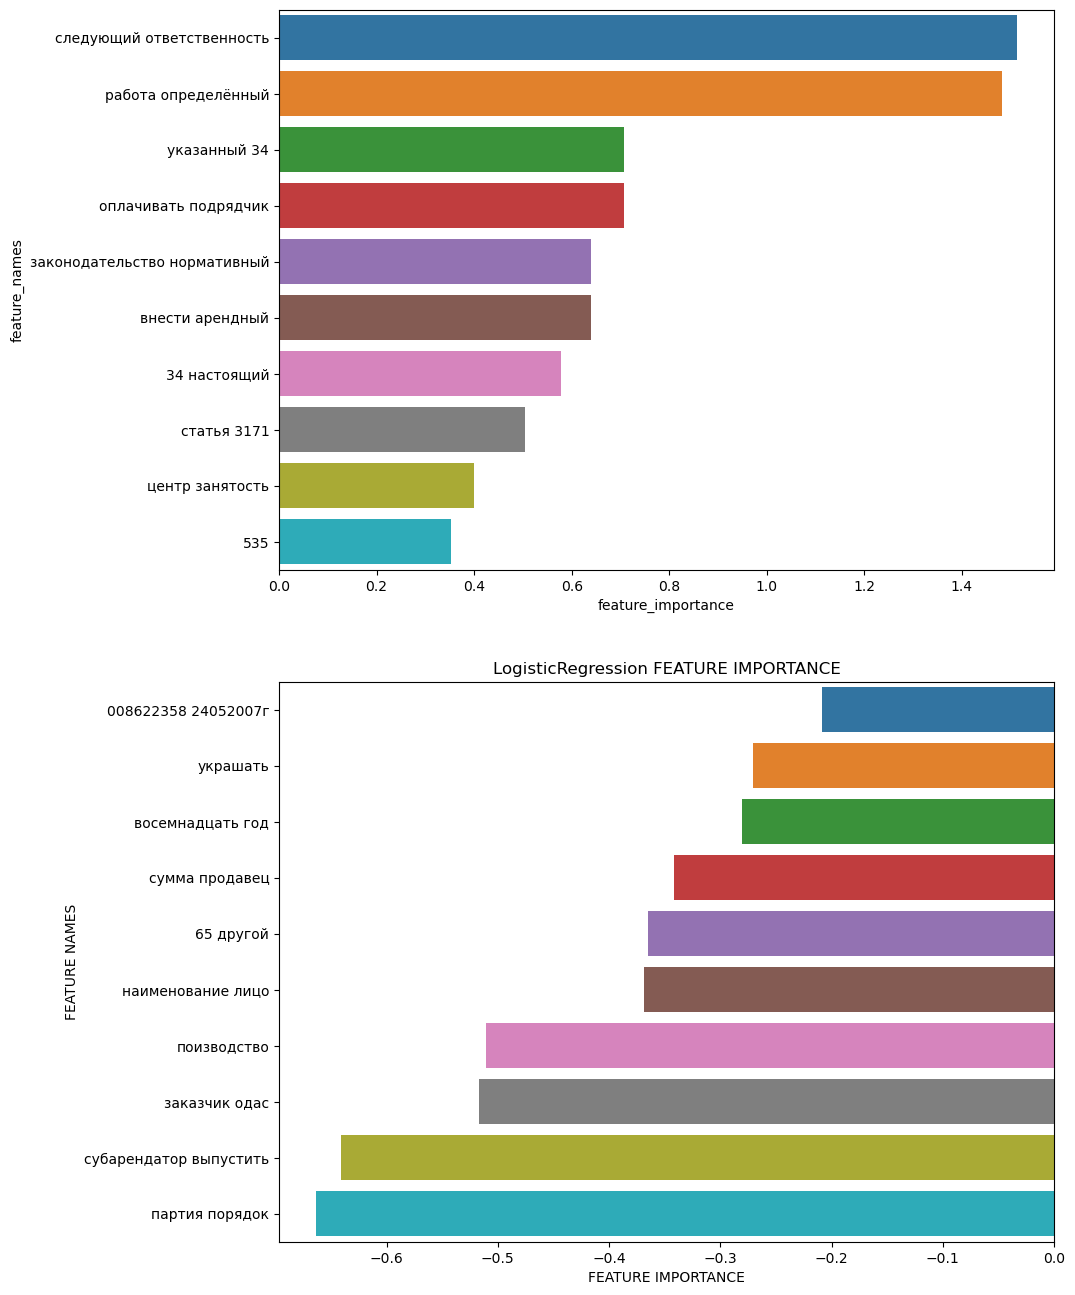

Wall time: 4.28 s


In [21]:
%%time
LR = LogisticRegression(random_state=42)
tf, LR_trained_classifier = learning(X_train, X_test, y_train, y_test, LR,
                                     'LogisticRegression', ngram_range_user=(1,2), plot_lsa=True)

In [ ]:
stop_words = set(stopwords.words('russian')) # множество стоп слов

morph = pymorphy2.MorphAnalyzer() # для постановки слова в начальную форму

def lemmatize_words(text):
    '''Функция для лемматизации отдельных слов.'''
    final_text = []
    for i in text.lower().split():
        if i not in stop_words:
            parse = morph.parse(i)[0]
            if ('Abbr' not in parse.tag):
                final_text.append(parse.normal_form)               
    return " ".join(final_text)

def text_preprocessing(text):
    data = text.copy()

    # удаляем пунктуацию
    data['content_punct'] = data['content'].str.translate(str.maketrans('', '', string.punctuation))
    # Приводим к начальной форме
    data['content_punct_lemm'] = data['content_punct'].apply(lemmatize_words)
    
    return data

classes_prep = text_preprocessing(classes)


In [54]:
import joblib
joblib.dump(tf, 'tf.pkl') 
joblib.dump(LR_trained_classifier, 'LR_trained_classifier.pkl') 

#classifier2 = joblib.load('classifier.pkl')

['LR_trained_classifier.pkl']

In [57]:
cl = classes[0].unique()

In [58]:
cl

array(['Договоры для акселератора/Договоры поставки',
       'Договоры для акселератора/Договоры оказания услуг',
       'Договоры для акселератора/Договоры подряда',
       'Договоры для акселератора/Договоры аренды',
       'Договоры для акселератора/Договоры купли-продажи'], dtype=object)